# Generating the container 

In [ ]:
import argparse

import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass

from typing import List, Tuple

from ri_grad.components import *
import sys
print(sys.path)

['/usr/lib64/python311.zip', '/usr/lib64/python3.11', '/usr/lib64/python3.11/lib-dynload', '', '/home/vini/Documents/refindex_gradient/.venv/lib64/python3.11/site-packages', '/home/vini/Documents/refindex_gradient/.venv/lib/python3.11/site-packages']


In [8]:
class Geometry: 
    """
    height and width in centimeters
    """
    def __init__(
            self, 
            height=25, 
            width=40, 
        ):
        self.width = width
        self.height = height

In [ ]:
class Layer:
    def __init__(self, y_0, y_f, n):
        self.y_0 = y_0
        self.y_f = y_f
        self.n = n

In [9]:
class Renderer:
    def __init__(
            self, 
            geometry: Geometry, 
            n_layers=15
        ):
        self.geometry = geometry
        self.n_layers = n_layers

        fig, ax = plt.subplots()
        self.fig = fig
        self.ax = ax
        self._draw_aquarium()

    def render_geometry(self):
        plt.figure(self.fig.number)
        ax = self.ax

        # Draw the container (only bottom and left edges)
        ax.plot([0, self.geometry.width], [0, 0], color='black')
        ax.plot([0, 0], [0, self.geometry.height], color='black')

    def _draw_aquarium(self):
        plt.figure(self.fig.number) 
        ax = self.ax

        ax.set_xlim(0, self.container.width)
        ax.set_ylim(0, self.container.height)
        ax.set_aspect('equal')

        # Remove top and right spines to resemble an aquarium
        ax.spines['top'].set_visible(False)

        # Keep only the bottom and left spines
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')

        # Remove ticks
        ax.set_xticks([])

In [ ]:
class Layer:
    def __init__(self, y_0, y_f, n):
        self.y_0 = y_0
        self.y_f = y_f
        self.n = n

class Medium:
    def __init__(
        self, 
        container: Container, 
        n_0: float = 1.0, 
        n_f: float = 1.5, 
        n_layers: int = 15, 
        color: str = 'blue'
        ):

        self.container = container
        self.n_0 = n_0
        self.n_f = n_f
        self.n_layers = n_layers
        self.color = color

        self.layer_thickness = self.container.height / self.n_layers
        self.layers = self._create_layer_list()
    
    def _create_layer_list(self):
        layer_list = []
        y_0 = 0
        y_f = self.container.height / self.n_layers

        for i in range(self.n_layers):
            layer_list.append(Layer(y_0, y_f, self.get_layer_ri(i)))
            y_0 += y_f
        
        return layer_list

    def get_layer_from_y(self, y):
        index = self.n_layers - (y // self.layer_thickness) - 1
        return self.layers[index] if index >= 0 else self.layers[0]
    
    def get_layer_index_from_y(self, y):
        index = self.n_layers - (y // self.layer_thickness) - 1
        return index if index >= 0 else 0

In [ ]:
class Experiment:
    def __init__(self, container: Container, medium: Medium, beam: Beam):
        self.container = container
        self.medium = medium
        self.beam = beam

        fig, ax = plt.subplots()
        self.fig = fig
        self.ax = ax

        self._container_drawn = False

    def render_container(self):
        plt.figure(self.fig.number)
        ax = self.ax

        ax.set_xlim(0, self.container.width)
        ax.set_ylim(0, self.container.height)
        ax.set_aspect('equal')

        # Remove top and right spines to resemble an aquarium
        ax.spines['top'].set_visible(False)

        # Keep only the bottom and left spines
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')

        # Remove ticks
        ax.set_xticks([])

        self._container_drawn = True

    def render_medium(self):
        if not self._container_drawn:
            self.render_container()

        ax = self.ax
        n_layers = self.medium.n_layers

        # Generate a linear light to dark blue gradient
        gradient = np.linspace(.3, 1, n_layers)[::-1]
        colors = plt.cm.Blues(gradient)

        # Draw the layers with the generated colors
        ax = self.ax
        for i in range(n_layers):
            layer_height = i * (self.container.height / n_layers)
            ax.fill_between(
                [0, self.container.width], 
                layer_height, 
                layer_height + (self.container.height / self.medium.n_layers), 
                color=colors[i], 
                alpha=0.5
            )    
    """
    Receives a beam, an incidence point and an incidence angle.
    Calculates the refraction angles and points for each layer in the medium.
    """
    def _refraction(self, layer1: Layer, layer2: Layer, incidence_angle: float):        
        return np.arcsin((layer1.n / layer2.n) * np.sin(incidence_angle))
    
    def _refraction(self, n1: float, n2: float, incidence_angle: float):        
        return np.arcsin((n1 / n2) * np.sin(incidence_angle))
    
    """
    Calculates the point of incidence on the next layer. 
    """
    def _transmission(self, incidence_point: Tuple[float], refracted_angle: float):
        x_offset = self.medium.layer_thickness * np.tan(refracted_angle)
        return (incidence_point[0] + x_offset, incidence_point[1] + self.medium.layer_thickness)

    """
    The first refraction is a special case because the beam incides on the side wall of the container.
    Returns the point of incidence on the first layer and the incidence angle.
    """
    def _first_refraction(self, incidence_point: Tuple[float], incidence_angle: float):
        incidence_layer = self.medium.get_layer_from_y(incidence_point[1])
        y_offset = incidence_point[1] % self.medium.layer_thickness

        refracted_angle = self._refraction(0, incidence_layer.n, incidence_angle)
        x_offset = y_offset / np.tan(refracted_angle)

        return ((incidence_point[0] + x_offset, incidence_point[1] + y_offset), refracted_angle)

    """"
    Calculates the trajectory of the beam through the medium.
    Returns a list of points where the beam incides on each interface.
    """
    def beamOn(self):
        plt.figure(self.fig.number)
        ax = self.ax
        n_layers = n_layers
        
        points: List[Tuple[float]] = [] # list of points where the beam incides on each interface
        incidence_point: Tuple[float] = [0, beam.y_0]
        points.append(incidence_point)

        # first refraction
        incidence_point, incidence_angle = self._first_refraction((beam.x_0, beam.y_0), beam.angle)
        points.append(incidence_point)

        # remaining refractions
        incident_layer_index = self.medium.get_layer_index_from_y(incidence_point[1])
        for i in range(incident_layer_index, self.medium.n_layers):
            layer = self.medium.layers[i]
            next_layer = self.medium.layers[i + 1] if i + 1 < self.medium.n_layers else None
            
            if next_layer is None: # last layer, no refraction
                break
            
            refracted_angle = self._refraction(layer.n, next_layer.n, incidence_angle)
            incidence_point = self._transmission(incidence_point, refracted_angle)
            points.append(incidence_point)

        return points

    def show(self):
        plt.figure(self.fig.number)
        plt.show()

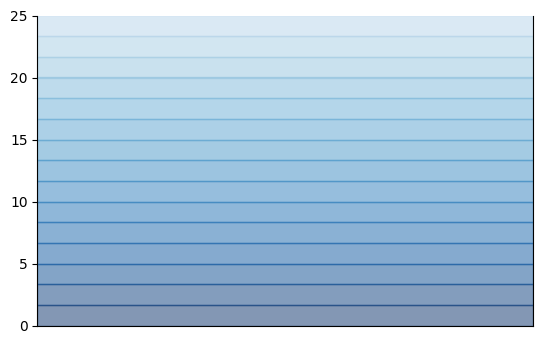

In [ ]:
# experiment setup
container = Container(width=40, height=25)
medium = Medium(
    container,
    n_0=1.0, 
    n_f=1.5, 
    n_layers=15, 
    color='blue'
)
beam = Beam(wavelength=500e-9, y_0=12.5, angle=np.pi/4)

experiment = Experiment(container, medium, beam)

# experiment.run()

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description="Refindex Gradient Experiment")
    parser.add_argument("name", type=str, help="Name of the experiment")
    parser.add_argument("n_layers", type=int, help="Number of layers in the medium")
    parser.add_argument("n_0", type=int, default=1.3, help="Refractive index of the first layer")
    parser.add_argument("n_f", type=int, default=1.5, help="Refractive index of the last layer")
    parser.add_argument("y_beam", type=float, default=25.0, help="Initial y position of the light beam in cm")
    
    return parser.parse_args()